In [19]:
import numpy as np
import pandas as pd
import obspy
from datetime import datetime
import matplotlib.pyplot as plt
import glob
from collections import defaultdict
import os
import re
import csv

%matplotlib inline

In [20]:
catalog_dir = "./data/lunar/training/catalogs/"
catalog_file = catalog_dir + "apollo12_catalog_GradeA_final.csv"
catalog = pd.read_csv(catalog_file)

In [21]:
quake_index = 7
row = catalog.iloc[quake_index]
quake_filename = row["filename"]
quake_time_abs = datetime.strptime(row["time_abs(%Y-%m-%dT%H:%M:%S.%f)"], "%Y-%m-%dT%H:%M:%S.%f")
quake_time_rel = row["time_rel(sec)"]
quake_event_id = row["evid"]
quake_type = row["mq_type"]

In [22]:
quake_index, quake_filename, quake_time_abs, quake_time_rel, quake_event_id, quake_type

(7,
 'xa.s12.00.mhz.1970-07-20HR00_evid00010',
 datetime.datetime(1970, 7, 20, 5, 6),
 np.float64(18360.0),
 'evid00010',
 'impact_mq')

In [23]:
train_data_dir = "./data/lunar/training/data/S12_GradeA/"
mseed_file = f"{train_data_dir}{quake_filename}.mseed"
st = obspy.read(mseed_file)

tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

In [24]:
from scipy import signal
from matplotlib import cm

f, t, sxx = signal.spectrogram(tr_data, tr.stats.sampling_rate)

minfreq = 0.5
maxfreq = 1.0

st_filt = st.copy()
st_filt.filter("bandpass", freqmin=minfreq, freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

f_filt, t_filt, sxx_filt = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)

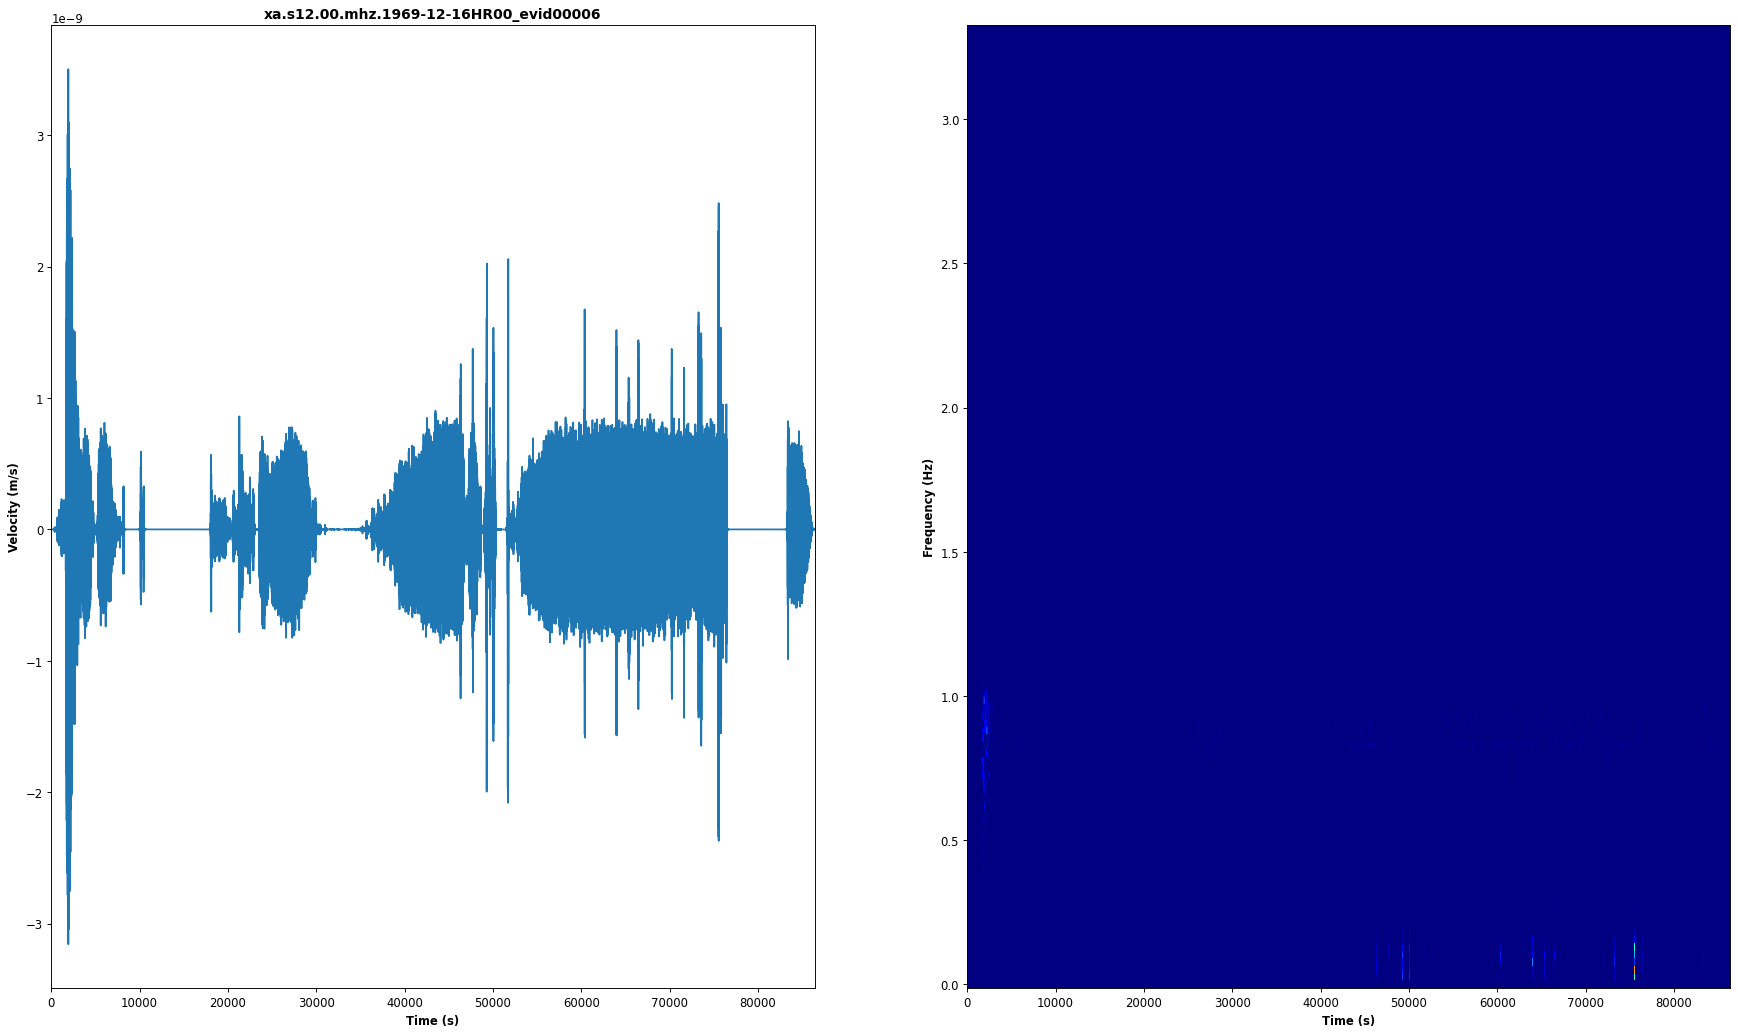

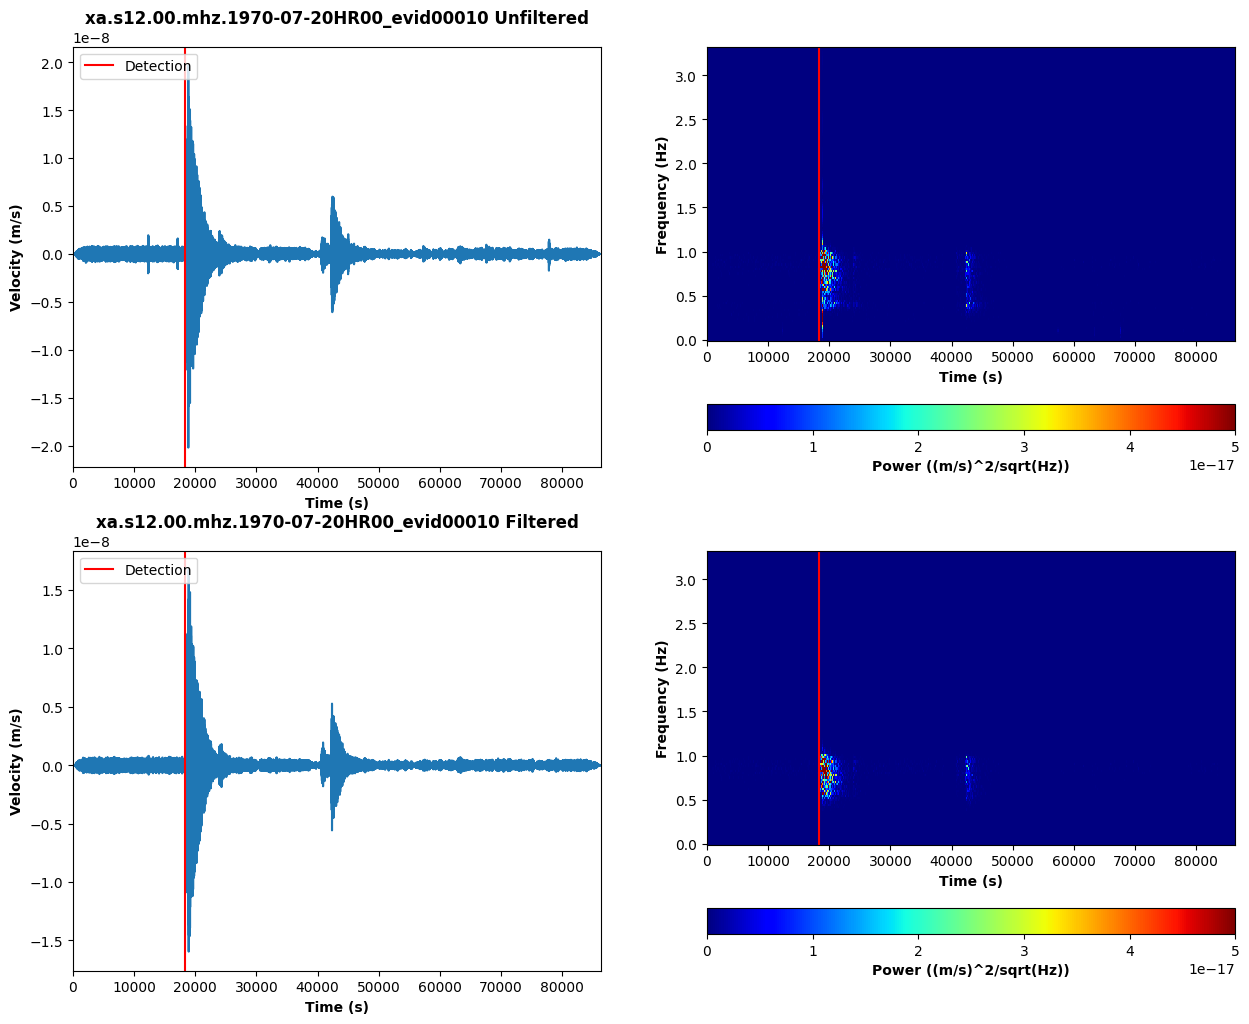

In [25]:
fig = plt.figure(figsize=(15, 12))

ax = plt.subplot(2, 2, 1)
ax.plot(tr_times, tr_data)

ax.axvline(x=quake_time_rel, color="red", label="Detection")
ax.legend(loc="upper left")

ax.set_title(f"{quake_filename} Unfiltered", fontweight="bold")
ax.set_xlim((min(tr_times), max(tr_times)))
ax.set_ylabel("Velocity (m/s)", fontweight="bold")
ax.set_xlabel("Time (s)", fontweight="bold")

ax2 = plt.subplot(2, 2, 2)
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)

ax2.set_xlim((min(tr_times), max(tr_times)))
ax2.set_xlabel(f"Time (s)", fontweight="bold")
ax2.set_ylabel("Frequency (Hz)", fontweight="bold")
ax2.axvline(x=quake_time_rel, c="red")

cbar = plt.colorbar(vals, orientation="horizontal")
cbar.set_label("Power ((m/s)^2/sqrt(Hz))", fontweight="bold")


ax = plt.subplot(2, 2, 3)
ax.plot(tr_times_filt, tr_data_filt)

ax.axvline(x=quake_time_rel, color="red", label="Detection")
ax.legend(loc="upper left")

ax.set_title(f"{quake_filename} Filtered", fontweight="bold")
ax.set_xlim((min(tr_times_filt), max(tr_times_filt)))
ax.set_ylabel("Velocity (m/s)", fontweight="bold")
ax.set_xlabel("Time (s)", fontweight="bold")

ax2 = plt.subplot(2, 2, 4)
vals = ax2.pcolormesh(t_filt, f_filt, sxx_filt, cmap=cm.jet, vmax=5e-17)

ax2.set_xlim((min(tr_times_filt), max(tr_times_filt)))
ax2.set_xlabel(f"Time (s)", fontweight="bold")
ax2.set_ylabel("Frequency (Hz)", fontweight="bold")
ax2.axvline(x=quake_time_rel, c="red")

cbar = plt.colorbar(vals, orientation="horizontal")
cbar.set_label("Power ((m/s)^2/sqrt(Hz))", fontweight="bold")

In [26]:
def get_mseed_files_list(path):
    return glob.glob(f"{path}/**/*.mseed")

def remove_evid_suffix(name):
    if match := re.match(r"(.*)_evid\d+(?:\.(?:csv|mseed))?", name):
        return match.group(1)

lunar_train_data_dir = "./data/lunar/training/data"
lunar_test_data_dir = "./data/lunar/test/data"

mars_train_data_dir = "./data/mars/training/data"
mars_test_data_dir = "./data/mars/test/data"

lunar_train_data_file_paths = get_mseed_files_list(lunar_train_data_dir)
lunar_test_data_file_paths = get_mseed_files_list(lunar_test_data_dir)

mars_train_data_file_paths = get_mseed_files_list(mars_train_data_dir)
mars_test_data_file_paths = get_mseed_files_list(mars_test_data_dir)

train_data_file_paths = lunar_train_data_file_paths + mars_train_data_file_paths
test_data_file_paths = lunar_test_data_file_paths + mars_test_data_file_paths

In [27]:
lunar_catalog_path = "./data/lunar/training/catalogs/apollo12_catalog_GradeA_final.csv"
mars_catalog_path = "./data/mars/training/catalogs/Mars_InSight_training_catalog_final.csv"

lunar_catalog = pd.read_csv(lunar_catalog_path)
assert len(lunar_catalog["filename"].tolist()) == len(lunar_train_data_file_paths)

lunar_events_per_file = defaultdict(int)
for filename in lunar_catalog["filename"]:
    lunar_events_per_file[remove_evid_suffix(filename)] += 1

mars_catalog = pd.read_csv(mars_catalog_path)
mars_catalog["filename"] = mars_catalog["filename"].apply(
    lambda name: name.replace(".csv", ".mseed")
)

mars_events_per_file = defaultdict(int)
for filename in mars_catalog["filename"]:
    mars_events_per_file[remove_evid_suffix(filename)] += 1

events_per_file = lunar_events_per_file | mars_events_per_file

print(sorted(events_per_file.items(), key=lambda kv: kv[1], reverse=True))

[('xa.s12.00.mhz.1970-07-20HR00', 2), ('xa.s12.00.mhz.1971-05-12HR00', 2), ('xa.s12.00.mhz.1972-07-17HR00', 2), ('xa.s12.00.mhz.1973-06-05HR00', 2), ('xa.s12.00.mhz.1974-07-06HR00', 2), ('xa.s12.00.mhz.1970-01-19HR00', 1), ('xa.s12.00.mhz.1970-03-25HR00', 1), ('xa.s12.00.mhz.1970-03-26HR00', 1), ('xa.s12.00.mhz.1970-04-25HR00', 1), ('xa.s12.00.mhz.1970-04-26HR00', 1), ('xa.s12.00.mhz.1970-06-15HR00', 1), ('xa.s12.00.mhz.1970-06-26HR00', 1), ('xa.s12.00.mhz.1970-09-26HR00', 1), ('xa.s12.00.mhz.1970-10-24HR00', 1), ('xa.s12.00.mhz.1970-11-12HR00', 1), ('xa.s12.00.mhz.1970-12-11HR00', 1), ('xa.s12.00.mhz.1970-12-27HR00', 1), ('xa.s12.00.mhz.1970-12-31HR00', 1), ('xa.s12.00.mhz.1971-01-15HR00', 1), ('xa.s12.00.mhz.1971-01-28HR00', 1), ('xa.s12.00.mhz.1971-01-29HR00', 1), ('xa.s12.00.mhz.1971-02-09HR00', 1), ('xa.s12.00.mhz.1971-03-25HR00', 1), ('xa.s12.00.mhz.1971-04-13HR00', 1), ('xa.s12.00.mhz.1971-04-17HR00', 1), ('xa.s12.00.mhz.1971-05-13HR00', 1), ('xa.s12.00.mhz.1971-05-23HR00', 1), 

In [28]:
catalog = lunar_catalog.copy()[["filename", "time_abs(%Y-%m-%dT%H:%M:%S.%f)", "time_rel(sec)"]]
catalog["filename"] = catalog["filename"].apply(remove_evid_suffix)
catalog

,filename,time_abs(%Y-%m-%dT%H:%M:%S.%f),time_rel(sec)
0,xa.s12.00.mhz.1970-01-19HR00,1970-01-19T20:25:00.000000,73500.0
1,xa.s12.00.mhz.1970-03-25HR00,1970-03-25T03:32:00.000000,12720.0
2,xa.s12.00.mhz.1970-03-26HR00,1970-03-26T20:17:00.000000,73020.0
3,xa.s12.00.mhz.1970-04-25HR00,1970-04-25T01:14:00.000000,4440.0
4,xa.s12.00.mhz.1970-04-26HR00,1970-04-26T14:29:00.000000,52140.0
...,...,...,...
71,xa.s12.00.mhz.1974-10-14HR00,1974-10-14T17:43:00.000000,63780.0
72,xa.s12.00.mhz.1975-04-12HR00,1975-04-12T18:15:00.000000,65700.0
73,xa.s12.00.mhz.1975-05-04HR00,1975-05-04T10:05:00.000000,36300.0
74,xa.s12.00.mhz.1975-06-24HR00,1975-06-24T16:03:00.000000,57780.0


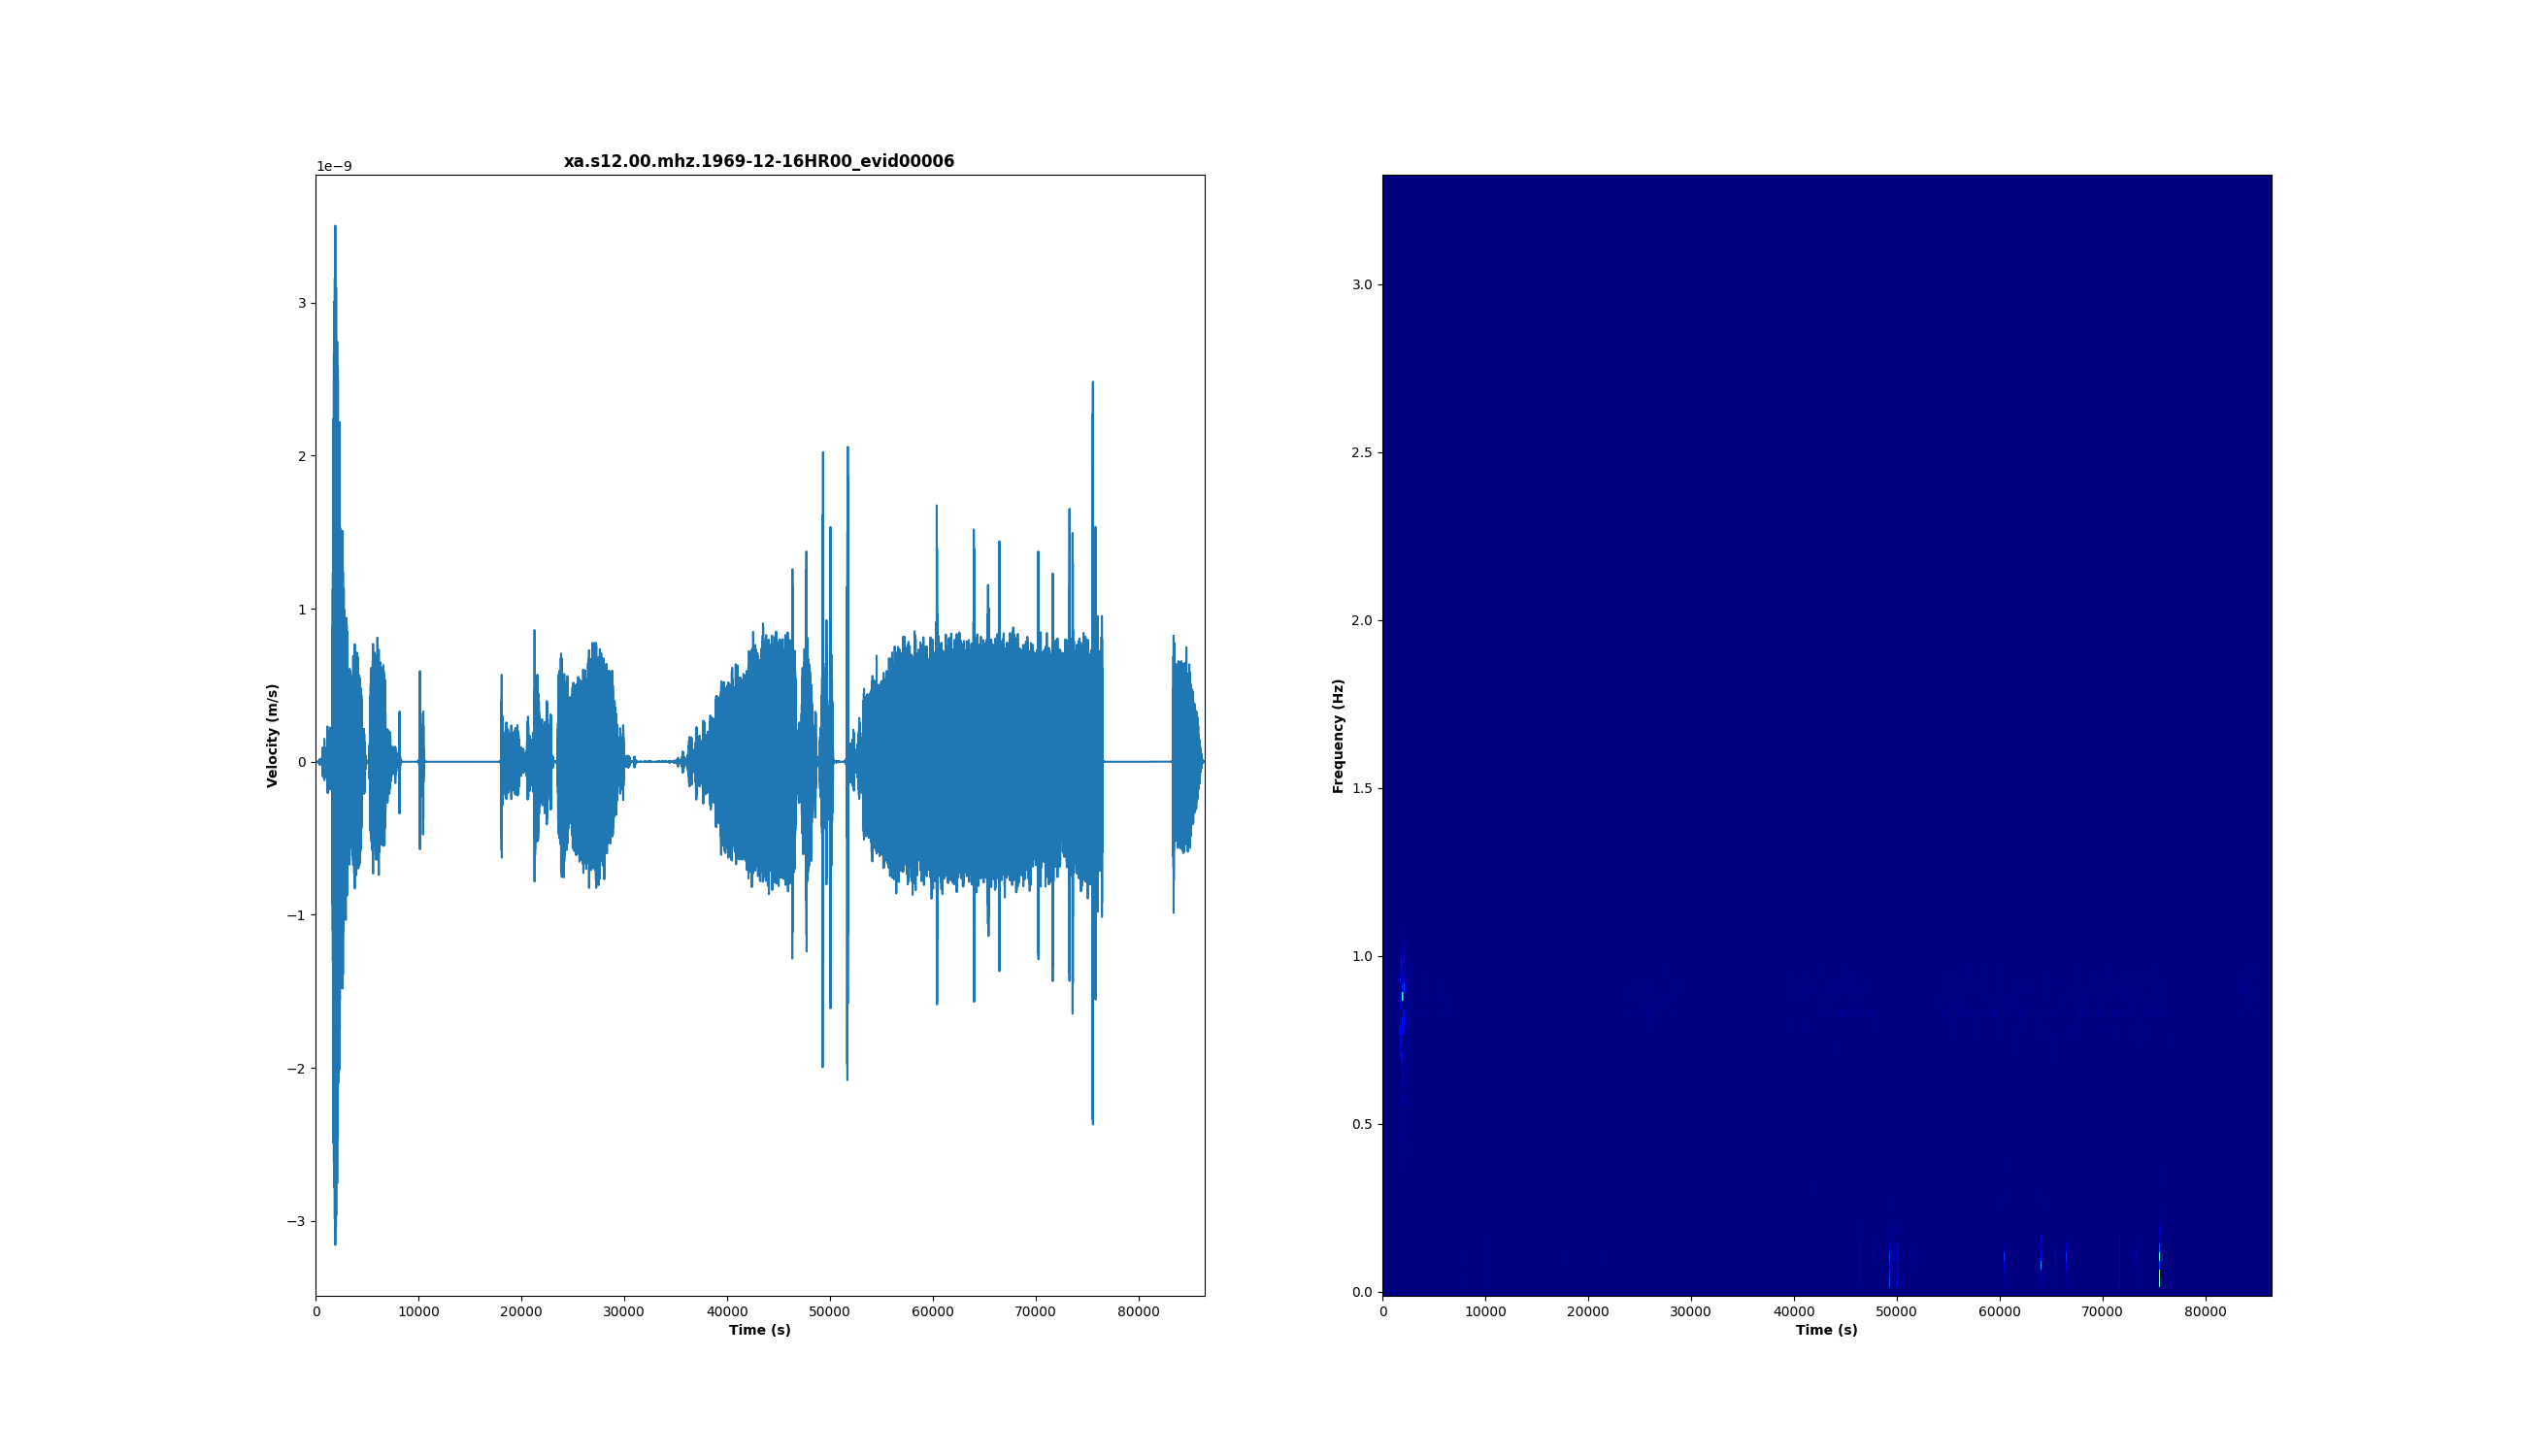

In [29]:
# Enable interactive plotting in the notebook
%matplotlib ipympl

x_coords_dict = {}  # Store x-coordinates for each file

with open("test_data_catalog.csv", "r") as data:
    for i, line in enumerate(csv.reader(data)):
        if i == 0:
            continue
        x_coords_dict[line[0]] = line[1]

# Global state
lines_dict = {}  # Store Line2D objects for each file

file_paths = test_data_file_paths  # List of file paths
current_file_index = 0  # Current file being viewed
max_file_index = len(file_paths) - 1  # Maximum file index
current_quake_index = 0  # Current quake index for adding/modifying lines

# Function to load seismic data from mseed files
def load_mseed_file(filepath):
    st = obspy.read(filepath)
    trace = st.traces[0].copy()
    times = trace.times()
    data = trace.data
    stats = trace.stats
    return times, data, stats

# Function to visualize the seismic data and quake times
# Function to visualize the seismic data and quake times
def visualise_file(ax1, ax2, filepath, title, quake_times=[]):
    times, data, stats = load_mseed_file(filepath)

    # Clear the first axis and plot time series data
    ax1.clear()
    ax1.plot(times, data)

    # Add new quake lines if any
    for i, quake_time in enumerate(quake_times):
        ax1.axvline(x=quake_time, color="red", linestyle="--", label=f"Quake {i + 1}")

    if quake_times:
        ax1.legend(loc="upper left")

    ax1.set_title(f"{title}", fontweight="bold")
    ax1.set_xlim((min(times), max(times)))
    ax1.set_ylabel("Velocity (m/s)", fontweight="bold")
    ax1.set_xlabel("Time (s)", fontweight="bold")

    # Spectrogram
    f, t, sxx = signal.spectrogram(data, stats.sampling_rate)
    ax2.clear()  # Clear the previous spectrogram
    ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)

    # Redraw existing lines on the spectrogram
    for i, quake_time in enumerate(quake_times):
        ax2.axvline(x=quake_time, color="red", linestyle="--")

    ax2.set_xlim((min(times), max(times)))
    ax2.set_xlabel("Time (s)", fontweight="bold")
    ax2.set_ylabel("Frequency (Hz)", fontweight="bold")


# Handle mouse clicks to add or modify vertical quake lines
def on_click(event):
    global current_quake_index, lines_dict, x_coords_dict
    if event.inaxes and event.button == 2:  # Left mouse button click
        x = event.xdata
        current_file = os.path.basename(file_paths[current_file_index]).replace(".mseed", "")

        # Initialize storage for this file if not present
        if current_file not in lines_dict:
            lines_dict[current_file] = []
            x_coords_dict[current_file] = []

        # Modify an existing line or add a new one
        if current_quake_index >= 0 and current_quake_index < len(lines_dict[current_file]):
            # Update existing line
            lines_dict[current_file][current_quake_index].set_xdata([x, x])

        elif current_quake_index == len(lines_dict[current_file]):
            # Add a new line
            new_line = ax1.axvline(x=x, color="r", linestyle="--", label=f"Quake {current_quake_index + 1}")
            lines_dict[current_file].append(new_line)
            # Also add to the spectrogram
            ax2.axvline(x=x, color="red", linestyle="--")

        # Update x-coordinates for the current file
        x_coords_dict[current_file] = [line.get_xdata()[0] for line in lines_dict[current_file]]

        # Redraw and update legend
        update_plot()
        ax1.legend(loc="upper left")

# Handle key press events to switch files, modify or delete lines
def on_press(event):
    global current_quake_index, current_file_index, lines_dict, x_coords_dict
    current_file = os.path.basename(file_paths[current_file_index]).replace(".mseed", "")

    if event.key in set(map(str, range(1, 10))):
        # Select the quake index to modify (1-9), but restrict to the number of existing lines
        new_index = int(event.key) - 1
        if new_index <= len(lines_dict.get(current_file, [])):
            current_quake_index = new_index
        else:
            current_quake_index = -1  # Reset if out of bounds

    elif event.key == "delete":
        # Delete the current quake line if it exists
        if current_file in lines_dict and current_quake_index >= 0 and current_quake_index < len(lines_dict[current_file]):
            lines_dict[current_file][current_quake_index].remove()  # Remove from plot
            del lines_dict[current_file][current_quake_index]  # Remove from dictionary
            del x_coords_dict[current_file][current_quake_index]
            current_quake_index = -1

            # Update plot after deletion
            update_plot()  # Redraw the plot after deletion

    elif event.key == "left" and current_file_index > 0:
        # Move to previous file
        current_file_index -= 1
        current_quake_index = -1  # Reset quake index
        update_plot()

    elif event.key == "right" and current_file_index < max_file_index:
        # Move to next file
        current_file_index += 1
        current_quake_index = -1  # Reset quake index
        update_plot()

# Function to update the plot when switching files
def update_plot():
    filepath = file_paths[current_file_index]
    current_file = os.path.basename(filepath).replace(".mseed", "")
    title = current_file

    # Get stored quake times for the current file or empty list
    quake_times = x_coords_dict.get(current_file, [])

    # Visualize the seismic data and quake lines for the new file
    visualise_file(ax1, ax2, filepath, title, quake_times)

    plt.draw()

# Initial plot setup
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(26, 15))  # Create subplots

# Connect mouse click and key press events
fig.canvas.mpl_connect("button_press_event", on_click)
fig.canvas.mpl_connect("key_press_event", on_press)

# Visualize the first file on startup
visualise_file(ax1, ax2, file_paths[0], os.path.splitext(os.path.basename(file_paths[0]))[0])
plt.show()

In [30]:
x_coords_dict

{'xa.s12.00.mhz.1969-12-16HR00_evid00006': '[1602.7656855833166]',
 'xa.s12.00.mhz.1970-01-09HR00_evid00007': '[7352.079718734576]',
 'xa.s12.00.mhz.1970-02-07HR00_evid00014': '[5499.912576092035, 12333.962584391873]',
 'xa.s12.00.mhz.1970-02-18HR00_evid00016': '[6131.678712149618, 43844.25223892913]',
 'xa.s12.00.mhz.1970-03-14HR00_evid00018': '[43339.25567802854]',
 'xa.s12.00.mhz.1970-03-30HR00_evid00020': '[46255.02991996621, 63622.080334728314]',
 'xa.s12.00.mhz.1970-04-03HR00_evid00021': '[38858.84894598203]',
 'xa.s12.00.mhz.1970-05-20HR00_evid00026': '[60458.34405328089]',
 'xa.s12.00.mhz.1970-05-23HR00_evid00027': '[47340.30237328546]',
 'xa.s12.00.mhz.1970-05-24HR00_evid00028': '[16715.52591808778]',
 'xa.s12.00.mhz.1970-05-25HR00_evid00029': '[44017.18397820294]',
 'xa.s12.00.mhz.1970-06-19HR00_evid00031': '[9788.548211026504, 77319.45961767482]',
 'xa.s12.00.mhz.1970-07-17HR00_evid00035': '[18083.87816049085]',
 'xa.s12.00.mhz.1970-07-18HR00_evid00036': '[2033.1828676499308

In [31]:
import json

with open("test_data_catalog.csv", "w", newline="") as csv_file:
    writer = csv.writer(csv_file)
    writer.writerow(["filename"," time_rel(sec)"])
    for key, value in x_coords_dict.items():
        proper_list = json.loads(value)
        times = list(map(lambda x: float(x), proper_list))
        writer.writerow([key, times])